# Analytical Derivation of the dynamical Equations

In [1]:
import sympy

In [2]:
from sympy.physics.quantum import TensorProduct

In [3]:
from sympy import I, exp, sqrt

In [4]:
import numpy as np

In [5]:
sympy.init_printing()

In [6]:
from IPython.display import display, Math

In [7]:
def multiply_eq(eq, c, simplify=sympy.expand):
    """Multiply an equation with a constant"""
    return sympy.Eq(simplify(eq.lhs*c), simplify(eq.rhs*c))

In [8]:
def divide_eq(eq, c, simplify=sympy.expand):
    """Divide an equation by constant"""
    return sympy.Eq(simplify(eq.lhs/c), simplify(eq.rhs/c))

In [9]:
def add_eqs(eq1, eq2, fac1=1, fac2=1, simplify=sympy.expand):
    """Add two equations"""
    return sympy.Eq(
        simplify(fac1 * eq1.lhs + fac2 * eq2.lhs),
        simplify(fac1 * eq1.rhs + fac2 * eq2.rhs)
    )

In [10]:
def display_eqs(eqs):
    for eq in eqs:
        display(eq)

## Hamiltonian

The Hilbert space is the tensor product of qubit 1, qubit 2, cavity 1, cavity 2, all are TLS

In [11]:
def ketbra(i,j):
    level = {'e': 1, 'g': 0, '1':1, '0':0, 1:1, 0:0}
    i = level[i]
    j = level[j]
    result = {
        (0,0): sympy.Matrix([(1,0), (0,0)]),
        (0,1): sympy.Matrix([(0,1), (0,0)]),
        (1,0): sympy.Matrix([(0,0), (1,0)]),
        (1,1): sympy.Matrix([(0,0), (0,1)]),
    }
    return result[(i,j)]

In [12]:
def dagger(obj):
    return obj.conjugate().transpose()

In [13]:
Id = sympy.Matrix([(1,0), (0,1)])

In [14]:
δ1, δ2, g1, g2, Δ, κ, t \
= sympy.symbols((r'\delta_1', r'\delta_2', 'g_1', 'g_2',
                 r'\Delta', r'\kappa', 't'), positive=True)
ω1, ω2, g1t, g2t, ϕ1, ϕ2 \
= sympy.symbols((r'\delta\omega_1', r'\delta\omega_2', r'g_1', r'g_2',
                 '\phi_1', '\phi_2'), cls=sympy.Function)

In [15]:
H1 = -δ1 * TensorProduct(Id, Id, ketbra(1,1), Id) \
    + (g1**2/Δ) * TensorProduct(ketbra('g', 'g'), Id, ketbra(1,1), Id) \
    + ω1(t) * TensorProduct(ketbra('e', 'e'), Id, Id, Id) \
    - I * g1t(t) * (
        exp(I*ϕ1(t)) * TensorProduct(ketbra('e', 'g'), Id, ketbra(1,1), Id)
        - exp(-I*ϕ1(t)) * TensorProduct(ketbra('g', 'e'), Id, ketbra(1,1), Id)
      )

In [16]:
H2 = -δ2 * TensorProduct(Id, Id, Id, ketbra(1,1)) \
    + (g2**2/Δ) * TensorProduct(Id, ketbra('g', 'g'), Id, ketbra(1,1)) \
    + ω2(t) * TensorProduct(Id, ketbra('e', 'e'), Id, Id) \
    - I * g2t(t) * (
        exp(I*ϕ2(t)) * TensorProduct(Id, ketbra('e', 'g'), Id, ketbra(1,1))
        - exp(-I*ϕ2(t)) * TensorProduct(Id, ketbra('g', 'e'), Id, ketbra(1,1))
      )

In [17]:
L = sqrt(2*κ) * (  TensorProduct(Id, Id, ketbra(0,1), Id)
                 + TensorProduct(Id, Id, Id, ketbra(0,1)) )

In [18]:
H_int = - I * κ * (
            TensorProduct(Id, Id, ketbra(1,1), Id)
          + TensorProduct(Id, Id, Id, ketbra(1,1))
          + 2 * TensorProduct(Id, Id, ketbra(0,1), ketbra(1,0))
        )
# The above is the "effective" interaction term, including the non-Hermitian MCWF contribution
# We want the Hermitian Hamiltonian, not the effective Hamiltonian given in the paper
# (or maybe we don't -- this isn't entirely clear)
H_int += (I/2) * (dagger(L) * L)

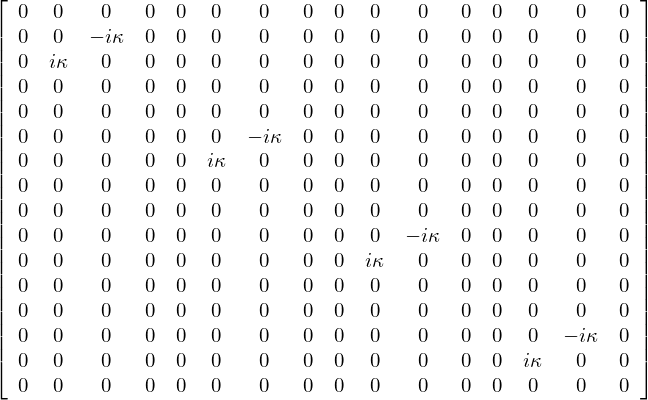

In [19]:
H_int

In [20]:
H = H1 + H2 + H_int 

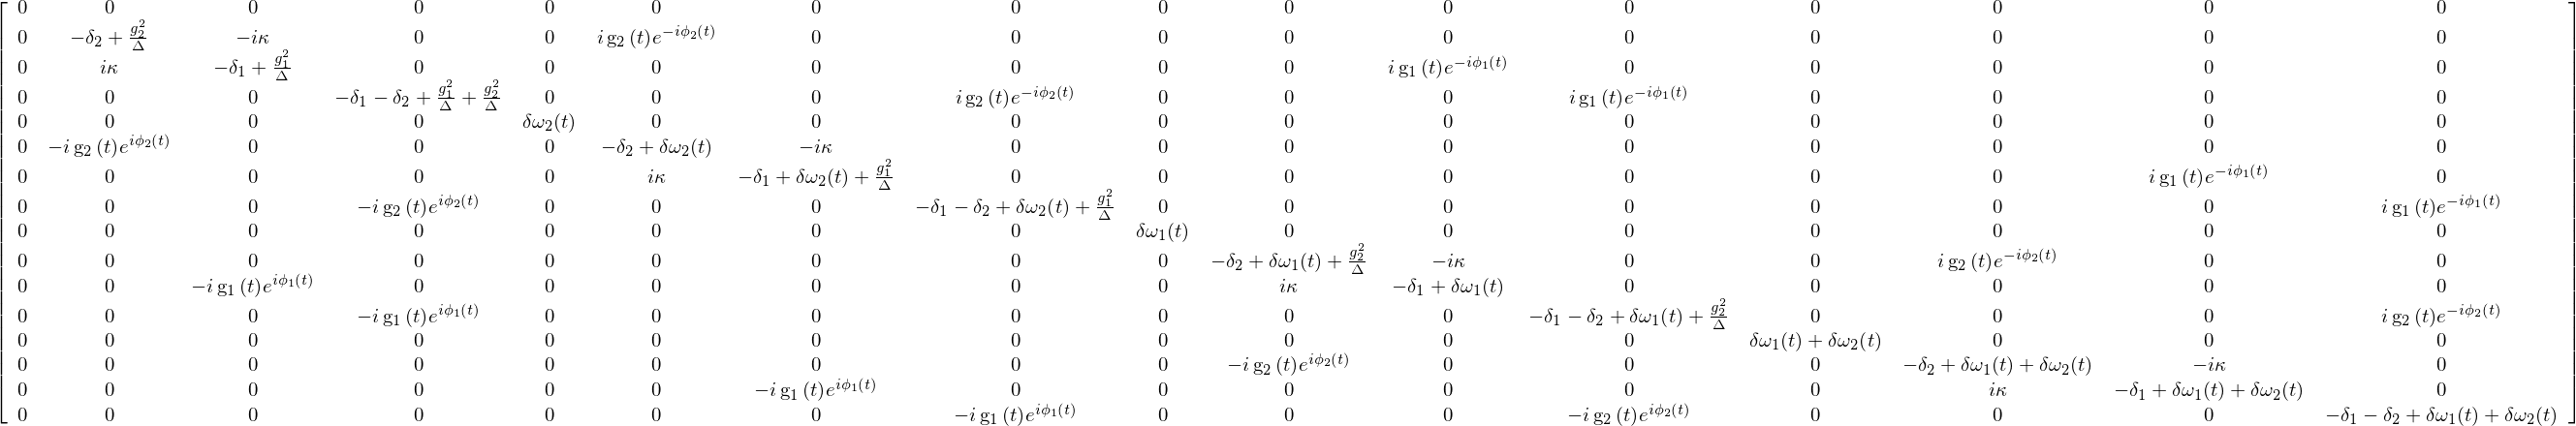

In [21]:
H

* Some of the constants are the same for both systems

In [22]:
δ, g = sympy.symbols((r'\delta', 'g'), positive=True)

In [23]:
H = H.subs({δ1:δ, δ2:δ, g1:g, g2:g})

The above Hamiltonian has been cross-checked with the output from QNET (application of SLH).

*  Choose the detuning

In [24]:
H = H.subs({δ: g**2/Δ})

* we may or may not claim a-priori that we can choose the the pulse phases such that they cancel the stark shifts

In [25]:
drop_phase_and_stark_shift = False # set to false to leave this for later

In [26]:
if drop_phase_and_stark_shift:
    zero_phase_zero_stark = {
            ϕ1(t): 0, ϕ2(t): 0,
            ω1(t): 0, ω2(t): 0}
    H = H.subs(zero_phase_zero_stark)

This yields the following Hamitonian:

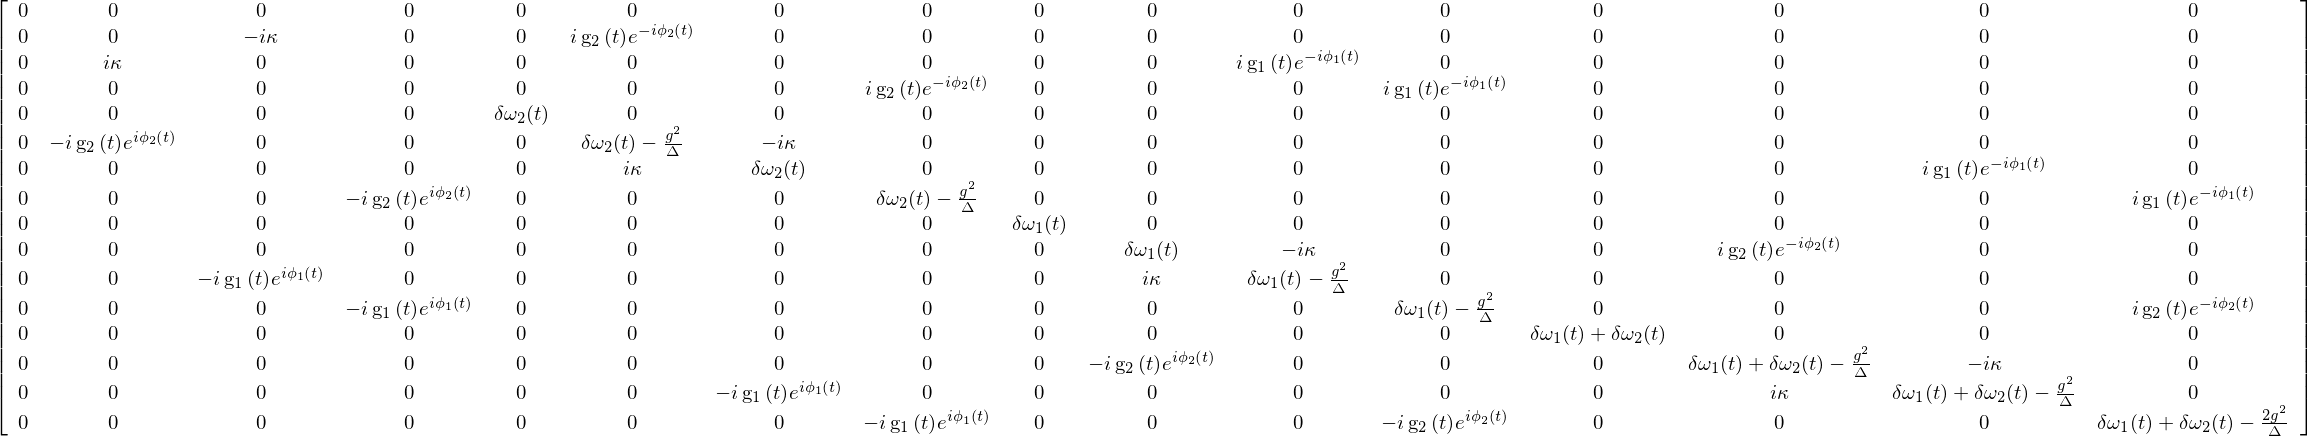

In [27]:
H

## State Parametrization (Ansatz)

In [28]:
ket0 = sympy.Matrix([1,0])
ket1 = sympy.Matrix([0,1])

In [29]:
def ket(*i_tupel):
    basis = {'e': ket1, 'g': ket0, '1':ket1, '0':ket0, 1:ket1, 0:ket0}
    result = basis[i_tupel[0]]
    for i in i_tupel[1:]:
        result = TensorProduct(result, basis[i])
    return result

In [30]:
def bra(*i_tupel):
    return dagger(ket(*i_tupel))

In [31]:
cg, ce = sympy.symbols(
(r'c_g', r'c_e'), positive=True)
α1, α2, β1, β2, βa, βs = sympy.symbols(
(r'\alpha_1', r'\alpha_2', r'\beta_1',
r'\beta_2', r'\beta_a', r'\beta_s'), cls=sympy.Function, positive=True)

In [32]:
Psi \
=   cg * ket('g', 'g', 0, 0) \
  + ce * (
          α1(t) * exp(-I*ϕ1(t)) * ket('e', 'g', 0, 0)
        + α2(t) * exp(-I*ϕ2(t)) * ket('g', 'e', 0, 0)
        + β1(t) * ket('g', 'g', 1, 0)
        + β2(t) * ket('g', 'g', 0, 1)
    )

In [33]:
if drop_phase_and_stark_shift:
    Psi = Psi.subs(zero_phase_zero_stark)

In [34]:
def print_psi(psi, skip_zero=True):
    from IPython.display import display, Math
    qubit = {'0': 'g', '1': 'e'}
    cav = {'0': '0', '1': '1'}
    for i, a in enumerate(psi):
        if a == 0:
            if skip_zero:
                continue
        i, j, k, l = "{0:04b}".format(i)
        label = qubit[i] + qubit[j] + cav[k] + cav[l]
        line = r'\langle %s \vert \Psi \rangle = %s ' \
               % (label, sympy.latex(a))
        display(Math(line))

* Let's assume the initial state is the fully excited state:

In [35]:
#Psi = Psi.subs({cg: 0, ce: 1})

* Boundary conditions:

In [36]:
boundary_start = {  # -infty
    cg: 0, ce: 1, α2(t): 1, ϕ2(t): 0, α1(t): 0, ϕ1(t) :0,
    β1(t): 0, β2(t): 0
}

In [37]:
boundary_end = {  # -infty
    cg: 0, ce: 1, α2(t): 0, ϕ2(t): 0, α1(t): 1, ϕ1(t) :0,
    β1(t): 0, β2(t): 0
}

In [38]:
print_psi(Psi.subs(boundary_start))

<IPython.core.display.Math object>

In [39]:
print_psi(Psi.subs(boundary_end))

<IPython.core.display.Math object>

* We rewrite the $\beta$ into a symmetric and anti-symmetric term.

In [40]:
beta_symmetry = {
    β1(t): ((βs(t) - βa(t)) / sqrt(2)),
    β2(t): ((βs(t) + βa(t)) / sqrt(2))
}

In [41]:
Psi = Psi.subs(beta_symmetry)

* The dark state condition is that probability of a quantum jump is zero:

In [42]:
eq_dark = sympy.Eq(((L * Psi)[0]).expand(), 0)

In [43]:
eq_dark

In [44]:
dark_state_cond = {βs(t): sympy.solve(eq_dark, βs(t))[0]}

In [45]:
Psi = Psi.subs(dark_state_cond)

In [46]:
print_psi(Psi, skip_zero=False)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

* Normalization condition

In [47]:
(dagger(Psi) * Psi)[0]

## Dynamic Equations

In [48]:
def dynamic_equations(H, psi, t):
    lhs = I*psi.diff(t)
    rhs = H * psi
    eqs = []
    for i in range(len(lhs)):
        if lhs[i] == rhs[i] == 0:
            continue
        else:
            eqs.append(sympy.Eq(lhs[i], rhs[i]))
    return eqs

In [49]:
eqs = dynamic_equations(H, Psi, t)

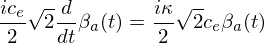

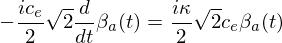

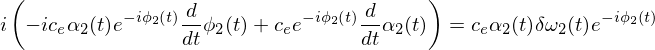

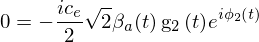

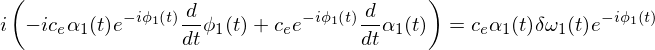

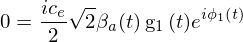

In [50]:
display_eqs(eqs)

* we assume that $c_e > 0$, and cancel constants

In [51]:
c1 = I*sqrt(2)*ce / 2
c2 = -I*ce

In [52]:
if drop_phase_and_stark_shift:
    eqs[0] = divide_eq(eqs[0], c1, simplify=sympy.simplify)
    eqs[1] = divide_eq(eqs[1], c1, simplify=sympy.simplify)
    eqs[2] = divide_eq(eqs[2], c2, simplify=sympy.simplify)
    eqs[3] = divide_eq(eqs[3], c1, simplify=sympy.simplify)
    eqs[4] = divide_eq(eqs[4], c2, simplify=sympy.simplify)
    eqs[5] = divide_eq(eqs[5], c1, simplify=sympy.simplify)
else:
    eqs[0] = divide_eq(eqs[0], c1, simplify=sympy.simplify)
    eqs[1] = divide_eq(eqs[1], c1, simplify=sympy.simplify)
    eqs[2] = divide_eq(eqs[2], (c2*exp(-I*ϕ2(t))), simplify=sympy.simplify)
    eqs[3] = divide_eq(eqs[3], (c1*exp(+I*ϕ2(t))), simplify=sympy.simplify)
    eqs[4] = divide_eq(eqs[4], (c2*exp(-I*ϕ1(t))), simplify=sympy.simplify)
    eqs[5] = divide_eq(eqs[5], (c1*exp(+I*ϕ1(t))), simplify=sympy.simplify)

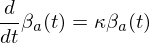

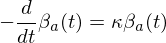

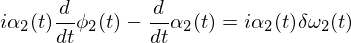

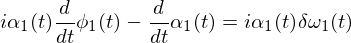

In [53]:
display_eqs(eqs)

* We choose a chirp to compensate for the Stark shift

In [54]:
if not drop_phase_and_stark_shift:
    chirp = {ϕ1(t).diff(t): ω1(t), ϕ2(t).diff(t): ω2(t)}
    for i, eq in enumerate(eqs):
        eqs[i] = eq.subs(chirp)

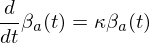

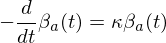

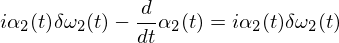

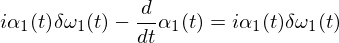

In [55]:
display_eqs(eqs)

In [56]:
eqs2 = []
eqs2.append(divide_eq(add_eqs(eqs[0], eqs[1]), 2))
eqs2.append(add_eqs(eqs[3], eqs[5]))
eqs2.append(eqs[2])
eqs2.append(eqs[4])

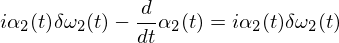

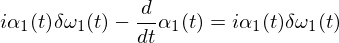

In [57]:
display_eqs(eqs2)